In [6]:
import numpy as np
from PIL import Image
## Data domain

## NCOLS and NROWS are the number of columns and rows in the raster defined by the ASCII file
N_COLS = 42
N_ROWS = 25

## XLLCORNER and YLLCORNER are the coordinates of the lower left corner of the lower left cell
XLL_CORNER = 14.000
YLL_CORNER = 49.000

## CELLSIZE is the cell size of the raster.
CELL_SIZE = 0.25

NO_DATA_VALUE = -99
UNIT = "mm"

import glob, os
import re
from datetime import datetime

data_path = "./data"
data_datetime_pattern = re.compile(r'^.*PERSIANN_6h(\d{10}).tif$')

def getDateTimeFromFileName(file_name):
    date_time_string = data_datetime_pattern.search(file_name).group(1)
    return datetime.strptime(date_time_string, '%Y%m%d%H')

def getTiffFileAsArray(file_name):
    return np.asarray(Image.open(file_name))
        

# get all files containing data
all_files = glob.glob(os.path.join(data_path, '*.tif'), recursive=False)

# load data into array of tuples
data = [(getDateTimeFromFileName(f), getTiffFileAsArray(f)) for f in all_files]


In [ ]:
<h1>The model</h1>

As suggested by a review on rainfall prediction [1], ANN based models do best for this particular task. Furthermore, as suggested by literature on rainfall prediction using ANNs, 3 hidden layers were used [2]

[1] https://www.researchgate.net/publication/319503839_Machine_Learning_Techniques_For_Rainfall_Prediction_A_Review
[2] https://www.researchgate.net/publication/260739937_A_rainfall_prediction_model_using_artificial_neural_network

In [ ]:
<h1>Visualizing the data</h1>

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

In [45]:
mean_data = [0 for _ in range(12)]
for month in range(12):
    mean_data[month] = [percipitation.flatten() for date_time, percipitation in data if (date_time.month - 1) == month]
    mean_data[month] = [p[p >= 0] for p in mean_data[month]])

fig, ax = plt.subplots()
ax.plot(range(12), mean_data)
ax.set(xlabel='month', ylabel='mean percipitation [mm]')
ax.grid()
plt.figure()
plt.show()

ValueError: operands could not be broadcast together with shapes (648,) (0,) 

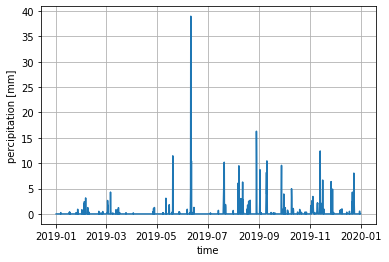

<Figure size 432x288 with 0 Axes>

In [43]:
def get_cell(x, y):
    """
    Gets data for given cell - filters out no data points and sorts by date
    """
    return sorted([(date_time, percipitation[y, x]) for date_time, percipitation in data if percipitation[y, x] >= 0], key=itemgetter(0))

t, s = zip(*get_cell(7, 7))
fig, ax = plt.subplots()
ax.plot(t, s)
ax.set(xlabel='time', ylabel='percipitation [mm]')
ax.grid()
plt.figure()
plt.show()